# CSI hypothesis testing on Met-Office data


In [1]:
import requests as req

import pandas as pd

import os
import re

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import numpy as np

import scipy as sp
import scipy.special as sp_spec

import jax.config as jc
jc.update('jax_enable_x64', True)
import jax
import jax.numpy as jn
import jax.scipy as js
import jax.random as jr
import csi_calc as cc

import IPython.display as ipyd

import datetime as dt
rnd_key = jr.PRNGKey(round(dt.datetime.now().timestamp()))

## Obtaining the data

The data is downloaded from the TXT files provided by the UK Met-Office

In [2]:
save_path = 'full_temperature_dataset.csv'

In [3]:
def extract_metoffice_temperature(
    text_url: str,
    chunk_size: int=1024*8
)->pd.DataFrame:
    """
    Load historical data from met-office. The expected format is a txt-file with structure
    
    <...>
    yyyy  mm   tmax    tmin      af    rain     sun
              degC    degC    days      mm   hours
    1853   1    ---     ---     ---    57.3     ---
    1853   2    ---     ---     ---    32.3     ---
    <...>
    1865   4   14.8     5.5       0    25.7     ---
    1865   5   15.7     8.0       0   108.9     ---
    <...>
    
    This can be parsed using regular expressions
    
    Arguments:
    ----------
        text_url: url to the TXT file with data, e.g. https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/armaghdata.txt
        chunk_size: size of the chunk to download the data, see requests....iter_content
        
    Returns:
    --------
        Dataframe with columns year, month, temperature_degc
    """
    
    full_file_str = ''
    
    # load the file in chunks
    for chunk in req.get(text_url, stream=True).iter_content(chunk_size=chunk_size):
        chunk_str = chunk.decode()
        full_file_str += chunk_str
        
    # extract matches for year, month and temperature using regex. focus on tmax degc (i.e. the third column)
    all_matches = re.findall('^[\s]+([0-9]{4})[\s]+([0-9]{1,2})[\s]+([0-9]+.[0-9]+)', full_file_str, flags=re.MULTILINE)
    res_df = pd.DataFrame(
        [
            {'year': int(m[0]), 'month': int(m[1]), 'temperature_degc': float(m[2])} for m in all_matches
        ]
    ).sort_values(['year', 'month'])
    
    return res_df

#####

# list of files to download and parse
txt_list = [
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/armaghdata.txt',
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/bradforddata.txt',
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/durhamdata.txt',
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/oxforddata.txt',
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/southamptondata.txt',
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/sheffielddata.txt',
    'https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/stornowaydata.txt'
]

df_list = []

# extract files one by one and append into a single list of dataframes
for cur_txt in txt_list:
    cur_location = os.path.basename(cur_txt).replace('data.txt', '')
    cur_df = extract_metoffice_temperature(cur_txt).assign(location=cur_location)
    print(f'Done {cur_location}, got {len(cur_df)} records')
    
    df_list.append(cur_df)
    
### 

# combine into one big dataframe and save
full_temperature_df = pd.concat(df_list)
full_temperature_df.to_csv(save_path, index=False)

full_temperature_df.head(5)

Done armagh, got 1890 records
Done bradford, got 1367 records
Done durham, got 1712 records
Done oxford, got 2035 records
Done southampton, got 1732 records
Done sheffield, got 1652 records
Done stornoway, got 1788 records


,year,month,temperature_degc,location
0,1865,4,14.8,armagh
1,1865,5,15.7,armagh
2,1865,6,21.0,armagh
3,1865,7,20.5,armagh
4,1865,8,19.0,armagh


It is convenient to work only with years where all 12 measurements are present. Capture this into a flag

In [4]:
flag_list = []

for (location, year), sub_df in full_temperature_df.groupby(['location', 'year']):
    full_year_present = int(len(sub_df)==12)
    flag_list.append({
        'location': location,
        'year': year,
        'full_year_present': full_year_present
    })
    
###

ext_full_temperature_df = full_temperature_df.merge(
    right=pd.DataFrame(flag_list), on=['year', 'location'], how='left'
)

# full_year_present=1 signals that full year of measurements is present for this location and year
ext_full_temperature_df.head(10)

,year,month,temperature_degc,location,full_year_present
0,1865,4,14.8,armagh,0
1,1865,5,15.7,armagh,0
2,1865,6,21.0,armagh,0
3,1865,7,20.5,armagh,0
4,1865,8,19.0,armagh,0
5,1865,9,20.4,armagh,0
6,1865,10,13.7,armagh,0
7,1865,11,9.6,armagh,0
8,1865,12,9.7,armagh,0
9,1866,1,8.2,armagh,1


## Set up left/right comparison  

Choose a location as a base, create a histogram that splits obsrevations for this location into equal bins, then chunk up observations for all locations into histograms using the splits calculated before. Make number of years the histogram is aggergated over tuneable

In [5]:
hist_choice_location = 'southampton'
upper_year_cutoff = 1990
lower_year_cutoff = 1800
cat_count = 10

clean_df = ext_full_temperature_df.query(f'full_year_present==1 & year>={lower_year_cutoff} & year<={upper_year_cutoff}')

# obtain bin_bounds, drag the lower and upper way out to ensure all temperatures will be captured
temperature_arr = clean_df.query(f'location=="{hist_choice_location}"').temperature_degc.values
temperature_bins = np.quantile(temperature_arr, q=np.arange(cat_count+1)*(1./cat_count))
temperature_bins[0] -= 100.
temperature_bins[-1] += 100.

print(temperature_bins)

[-98.8    7.6    9.    10.2   12.    14.25  16.4   18.4   20.    21.4
 126.8 ]


Now create aggretaed histograms

In [6]:
chunk_size_years = 10
bin_bias = 1e-2 # to prevent taking logit(0)

agg_geos_list = []
for location, choice_df in clean_df.groupby('location'):
    
    # for each location aggregate histograms over the number of years
    # we are not keeping the time-stamps of the specific histograms
    # the main focus will be on differences between locations
    years_agg = 0
    hist_list = []
    cur_agg = None
    
    for year, sub_df in choice_df.sort_values('year').groupby('year'):
        # get the current historgram
        cur_hist = np.histogram(sub_df.temperature_degc, bins=temperature_bins)[0]

        # aggeragare a certain number of years into the common histogram, then
        # add that to the list and move on to the next histogram
        if cur_agg is None:
            cur_agg = cur_hist
        elif (years_agg+2) < chunk_size_years:
            cur_agg += cur_hist
            years_agg += 1
        else:
            cur_agg += cur_hist
            hist_list.append(cur_agg)
            cur_agg = None
            years_agg = 0

    ###
    
    # get basic histogram matrix
    hist_arr = np.stack(hist_list, axis=0)
    
    # get the matrix of logits
    norm_hist_arr = hist_arr + bin_bias
    norm_hist_arr /= np.repeat(np.sum(norm_hist_arr, axis=1)[:, None], axis=1, repeats=hist_arr.shape[1])
    logit_arr = sp_spec.logit(norm_hist_arr)
    
    # estimate the mean and standard deviation in logits
    logit_mean = np.mean(logit_arr)
    logit_std = np.std(logit_arr)
    
    agg_geos_list.append({
        'location': location,
        'hist_arr': hist_arr,
        'logit_arr': logit_arr,
        'logit_std': logit_std,
        'logit_mean': logit_mean
    })
    
######

print(agg_geos_list[-2])

agg_geos_df = pd.DataFrame([
    {
        'location': d['location'],
        'logit_mean': d['logit_mean'],
        'logit_std': d['logit_std'],
    }
    for d in agg_geos_list
])

ipyd.display(agg_geos_df)
print(f'Expected logit mean for the number of categories is logit(1/{cat_count})={sp_spec.logit(1/cat_count):.3f}')

{'location': 'southampton', 'hist_arr': array([[13, 17, 11,  8, 10, 13, 15, 11,  9, 13],
       [17, 10, 10, 13, 12, 13,  9, 11, 11, 14],
       [12, 16, 14,  7, 16, 10, 15, 12, 10,  8],
       [20,  8, 13,  8, 13, 12,  7, 13, 14, 12],
       [10, 14, 10, 12, 12, 14,  6, 11,  9, 22],
       [ 9, 13, 15, 12, 10, 13, 14,  9, 17,  8],
       [14, 10, 14, 13, 12,  7, 13, 19, 12,  6],
       [11, 12, 14, 12, 13, 13, 10,  8, 15, 12],
       [13,  8, 13, 11, 14,  9, 12, 19,  8, 13],
       [ 9,  9, 10, 14, 14, 13, 11, 14, 10, 16],
       [10, 15,  6, 12, 14, 11, 10, 13, 16, 13],
       [ 7, 12, 14, 16, 11, 11, 14,  7, 14, 14],
       [12, 13, 12, 13,  8, 16,  9, 17,  9, 11]]), 'logit_arr': array([[-2.10795131, -1.80180099, -2.29336928, -2.63861136, -2.39771362,
        -2.10795131, -1.94610048, -2.29336928, -2.51200561, -2.10795131],
       [-1.80180099, -2.39771362, -2.39771362, -2.10795131, -2.19722458,
        -2.10795131, -2.51200561, -2.29336928, -2.29336928, -2.02451643],
       [-2.197

,location,logit_mean,logit_std
0,armagh,-2.504066,1.224885
1,bradford,-2.532054,1.165950
2,durham,-2.503097,1.198300
3,oxford,-2.253934,0.383280
4,sheffield,-2.363208,0.678083
5,southampton,-2.228257,0.282122
6,stornoway,-4.086326,3.393122


Expected logit mean for the number of categories is logit(1/10)=-2.197


Compute all combinations of CSI for the last histograms in the observations

In [7]:
csi_compute_list = []

for left_dict in agg_geos_list:
    for right_dict in agg_geos_list:
        left_hist = left_dict['hist_arr'][-1,:]
        right_hist = right_dict['hist_arr'][-1,:]
        
        cur_csi = cc.compute_csi(
            left_hist=left_hist,
            right_hist=right_hist,
            default_inc=1e-3
        )
        
        csi_compute_list.append({
            'left_location': left_dict['location'],
            'right_location': right_dict['location'],
            'csi': float(cur_csi)
        })
        
csi_compute_df = pd.DataFrame(csi_compute_list)
csi_compute_df.query(f'left_location=="{hist_choice_location}"').head(10)

,left_location,right_location,csi
35,southampton,armagh,0.358164
36,southampton,bradford,0.460039
37,southampton,durham,0.354577
38,southampton,oxford,0.084683
39,southampton,sheffield,0.240316
40,southampton,southampton,0.000000
41,southampton,stornoway,3.293561


## CSI threshold to reject null

Lets say the null hypothesis is that both left and right histograms came from the multinomial distribution where all logits are equal and standard deviation is the same as for `hist_choice_location`. What is the distribution of the CSIs? What is the 95% precentile

In [8]:
base_logits = jn.array([1./cat_count]*cat_count)
logit_std = agg_geos_df.query(f'location=="{hist_choice_location}"').logit_std.values[0]
pop_count = chunk_size_years * 12 # number of measurements in each histogram (12 per year)

csi_draw_count = 300000 # number of CSI's to compute

rnd_key, csi_rnd_key = jr.split(rnd_key, num=1+1)
tick = dt.datetime.now()
#
csi_samples = cc.draw_csi_with_logit_variance(
    rnd_key=csi_rnd_key,
    base_logits=base_logits,
    logits_std=logit_std,
    sample_count=csi_draw_count,
    count_left=pop_count,
    count_right=pop_count
)
#
tock = dt.datetime.now()
time_delta = tock-tick
time_delta_sec = time_delta.seconds + time_delta.microseconds * 1e-6

highq = 0.95
highq_csi = jn.quantile(csi_samples, q=highq)

print(f'Time taken: {time_delta_sec:.3f} sec for {csi_draw_count} samples.')
print(f'Quantile q={highq:.3f} corresponds to CSI={highq_csi:.3e}')

Time taken: 20.006 sec for 300000 samples.
Quantile q=0.950 corresponds to CSI=4.519e-01


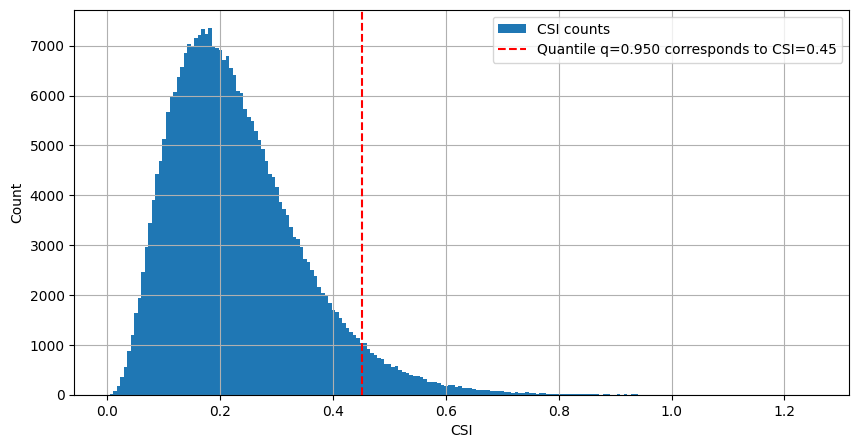

In [9]:
fig, ax = pp.subplots(figsize=(10, 5))

_ = ax.hist(csi_samples, bins=200, label='CSI counts')
ax.axvline(highq_csi, linestyle='--', color='r', label=f'Quantile q={highq:.3f} corresponds to CSI={highq_csi:.2f}')
ax.set_xlabel('CSI')
ax.set_ylabel('Count')
ax.grid()
ax.legend()

This can be used to decide whether CSIs for different locations are sufficiently different compared to `hist_choice_location`

In [10]:
csi_compute_df.query(f'left_location=="{hist_choice_location}"').assign(is_different=lambda old_df: old_df.csi > highq_csi)

,left_location,right_location,csi,is_different
35,southampton,armagh,0.358164,False
36,southampton,bradford,0.460039,True
37,southampton,durham,0.354577,False
38,southampton,oxford,0.084683,False
39,southampton,sheffield,0.240316,False
40,southampton,southampton,0.000000,False
41,southampton,stornoway,3.293561,True
